# Import Libraries

In [2]:
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

# Game Dialogue Generator ver.999

Creating a model that will magically predict the next words based on a text input.

OUR TEAM:

| Name | NIM |
|---|---|
|Shahran Kurnia Ramadhan|21/476650/PA/20592|
|Muhammad Linggar Ryanidha|21/475209/PA/20548|
|Daniel Ardi Chandra|21/479046/PA/20780|
|I Gusti Agung Premananda |21/473829/PA/20432|

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5069414469308419526
xla_global_id: -1
]


In [4]:
print(tf.__version__)

2.13.0


In [5]:
# Define path for file with datasets
dataset = '..\Datasets\VGCoST_VideoGameDialogue_Corpus\ENG\Portal_merged.txt'

# Define the datasets path
# dataset = '..\Datasets\Efonte_DiscoElysium_Dialogue\Efonte_DiscoElysium_dataset.txt'

# Read the data
with open(dataset, encoding='ISO-8859-1') as f:
    data = f.read()

# Remove unwanted characters using regex
data = re.sub(r"[@\[\"'\]]", "", data)

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus[i])

There are 5591 lines

The first 5 lines look like this:

cameras
glados says this if you place a portal on the wall under a camera.
to ensure the safe performance of all authorized activities, do not destroy 
vital testing apparatus.
for your own safety, do not destroy vital testing apparatus.


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [6]:
# # TESTING ONLY, COMMENT WHEN RUNNING FULL CODE
# corpus = corpus[:200]
# print(len(corpus))

200


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(f"Total words: {total_words}")

Total words: 435


In [8]:
tokenizer.word_index

{'the': 1,
 'you': 2,
 'to': 3,
 'of': 4,
 'this': 5,
 'a': 6,
 'your': 7,
 'not': 8,
 'test': 9,
 'and': 10,
 'please': 11,
 'aperture': 12,
 'science': 13,
 'chamber': 14,
 'we': 15,
 'turrets': 16,
 'are': 17,
 'testing': 18,
 'when': 19,
 'is': 20,
 'in': 21,
 'do': 22,
 'for': 23,
 'be': 24,
 'will': 25,
 'say': 26,
 'vital': 27,
 'apparatus': 28,
 'enrichment': 29,
 'center': 30,
 'good': 31,
 'that': 32,
 'have': 33,
 'on': 34,
 'safety': 35,
 'cube': 36,
 'device': 37,
 'if': 38,
 'however': 39,
 'there': 40,
 'now': 41,
 'as': 42,
 'part': 43,
 'destroy': 44,
 'own': 45,
 'weighted': 46,
 'storage': 47,
 'through': 48,
 'they': 49,
 'hello': 50,
 'i': 51,
 'me': 52,
 'no': 53,
 'ow': 54,
 'been': 55,
 'lock': 56,
 'any': 57,
 'protocol': 58,
 'an': 59,
 'required': 60,
 'glados': 61,
 'says': 62,
 'may': 63,
 'at': 64,
 'proceed': 65,
 'activated': 66,
 'here': 67,
 'can': 68,
 'them': 69,
 'hey': 70,
 'down': 71,
 'dont': 72,
 'error': 73,
 'again': 74,
 'has': 75,
 'one': 76

## Generating n_grams

In [9]:
def n_gram_seqs(corpus, tokenizer):
	input_sequences = []
	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]
		for i in range(1, len(token_list)):
			n_gram_sequence = token_list[:i+1]
			input_sequences.append(n_gram_sequence)
	return input_sequences

In [10]:
corpus[1:4]

['glados says this if you place a portal on the wall under a camera.',
 'to ensure the safe performance of all authorized activities, do not destroy ',
 'vital testing apparatus.']

In [11]:
# Test function
test_3_seq = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
test_3_seq

n_gram sequences for next 3 examples look like this:



[[61, 62],
 [61, 62, 5],
 [61, 62, 5, 38],
 [61, 62, 5, 38, 2],
 [61, 62, 5, 38, 2, 82],
 [61, 62, 5, 38, 2, 82, 6],
 [61, 62, 5, 38, 2, 82, 6, 83],
 [61, 62, 5, 38, 2, 82, 6, 83, 34],
 [61, 62, 5, 38, 2, 82, 6, 83, 34, 1],
 [61, 62, 5, 38, 2, 82, 6, 83, 34, 1, 144],
 [61, 62, 5, 38, 2, 82, 6, 83, 34, 1, 144, 84],
 [61, 62, 5, 38, 2, 82, 6, 83, 34, 1, 144, 84, 6],
 [61, 62, 5, 38, 2, 82, 6, 83, 34, 1, 144, 84, 6, 145],
 [3, 146],
 [3, 146, 1],
 [3, 146, 1, 85],
 [3, 146, 1, 85, 147],
 [3, 146, 1, 85, 147, 4],
 [3, 146, 1, 85, 147, 4, 86],
 [3, 146, 1, 85, 147, 4, 86, 148],
 [3, 146, 1, 85, 147, 4, 86, 148, 87],
 [3, 146, 1, 85, 147, 4, 86, 148, 87, 22],
 [3, 146, 1, 85, 147, 4, 86, 148, 87, 22, 8],
 [3, 146, 1, 85, 147, 4, 86, 148, 87, 22, 8, 44],
 [27, 18],
 [27, 18, 28]]

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [12]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 851
maximum length of sequences is: 16


## Add padding to the sequences

We padd the sequences so they have the same length and efficient when being feeded into the machine learning model.

In [13]:
# Pad the whole corpus
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (851, 16)


## Split the data into features and labels

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

In [14]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    return features, one_hot_labels

In [15]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (851, 15)
labels have shape: (851, 435)


In [16]:
from sklearn.model_selection import train_test_split

# RATIO for TRAIN / VAL / TEST: 60/20/20

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.25, random_state=42)

In [17]:
len(train_features), len(train_labels), len(val_features), len(val_labels), len(test_features), len(test_labels)

(510, 510, 170, 170, 171, 171)

# LSTM model

In [18]:
# Define the parameters
VOCAB_SIZE = total_words  
EMBEDDING_DIM = 256
EPOCH = 100

In [19]:
# Define the model
def create_model_lstm(rnn_units, dropout):
    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=max_sequence_len-1),
        Bidirectional(LSTM(rnn_units, dropout=dropout)), # This is the core GRU layer
        Dense(VOCAB_SIZE, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [20]:
# Define the hyperparameters
dropout = [0.2, 0.3, 0.4]
rnn_units = [128, 256, 512]
# dropout = [0.2]
# rnn_units = [128]

In [21]:
# Fix the Compatibility issue
tf.compat.v1.disable_eager_execution()

In [22]:
# Hyperparameter tuning for LSTM without keras wrapper
def hyperparameter_tuning_lstm(train_features, train_labels, val_features, val_labels):
    # Define the results dictionary
    results = {}

    # Loop over all possible combinations of hyperparameters
    for ru in rnn_units:
        for do in dropout:
            # Create the model using the current hyperparameters
            model = create_model_lstm(ru, do)
            model.fit(train_features, train_labels, epochs=5, verbose=2, validation_data=(val_features, val_labels))

            # Get the latest validation accuracy
            acc = model.history.history['val_accuracy'][-1]

            # Save the results
            results[(ru, do)] = acc
    return results

In [23]:
# Hyperparameter tuning for LSTM
result = hyperparameter_tuning_lstm(train_features, train_labels, val_features, val_labels)

Train on 510 samples, validate on 170 samples
Epoch 1/5


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


510/510 - 1s - loss: 5.9943 - accuracy: 0.0373 - val_loss: 5.9176 - val_accuracy: 0.0059 - 983ms/epoch - 2ms/sample
Epoch 2/5
510/510 - 1s - loss: 5.4052 - accuracy: 0.0471 - val_loss: 6.2738 - val_accuracy: 0.0529 - 567ms/epoch - 1ms/sample
Epoch 3/5
510/510 - 1s - loss: 5.1381 - accuracy: 0.0490 - val_loss: 6.5258 - val_accuracy: 0.0529 - 568ms/epoch - 1ms/sample
Epoch 4/5
510/510 - 1s - loss: 5.0673 - accuracy: 0.0569 - val_loss: 6.7817 - val_accuracy: 0.0471 - 565ms/epoch - 1ms/sample
Epoch 5/5
510/510 - 1s - loss: 5.0238 - accuracy: 0.0588 - val_loss: 6.8431 - val_accuracy: 0.0529 - 555ms/epoch - 1ms/sample
Train on 510 samples, validate on 170 samples
Epoch 1/5
510/510 - 1s - loss: 5.9926 - accuracy: 0.0373 - val_loss: 5.9090 - val_accuracy: 0.0059 - 1s/epoch - 3ms/sample
Epoch 2/5
510/510 - 1s - loss: 5.3853 - accuracy: 0.0412 - val_loss: 6.4056 - val_accuracy: 0.0059 - 699ms/epoch - 1ms/sample
Epoch 3/5
510/510 - 1s - loss: 5.1287 - accuracy: 0.0510 - val_loss: 6.5230 - val_acc

In [24]:
# Print the results LSTM hyperparameter tuning
for key, value in result.items():
    print(f"Hyperparameters: {key} \t Val Accuracy: {value}")
print(f"Best hyperparameters: {max(result, key=result.get)}")

Hyperparameters: (128, 0.2) 	 Val Accuracy: 0.052941177040338516
Hyperparameters: (128, 0.3) 	 Val Accuracy: 0.04117647185921669
Hyperparameters: (128, 0.4) 	 Val Accuracy: 0.03529411926865578
Hyperparameters: (256, 0.2) 	 Val Accuracy: 0.0470588244497776
Hyperparameters: (256, 0.3) 	 Val Accuracy: 0.01764705963432789
Hyperparameters: (256, 0.4) 	 Val Accuracy: 0.029411764815449715
Hyperparameters: (512, 0.2) 	 Val Accuracy: 0.05882352963089943
Hyperparameters: (512, 0.3) 	 Val Accuracy: 0.052941177040338516
Hyperparameters: (512, 0.4) 	 Val Accuracy: 0.04117647185921669
Best hyperparameters: (512, 0.2)


In [25]:
# Get the best hyperparameters
rnn_units_best = max(result, key=result.get)[0]
dropout_best = max(result, key=result.get)[1]

In [26]:
# Use the best hyperparameters to create the final model
model_lstm = create_model_lstm(rnn_units_best, dropout_best)

history = model_lstm.fit(train_features, train_labels, epochs=EPOCH, verbose=1, validation_data=(val_features, val_labels))

Train on 510 samples, validate on 170 samples
Epoch 1/100
510/510 [==============================] - 5s 11ms/sample - loss: 5.8464 - accuracy: 0.0353 - val_loss: 6.0121 - val_accuracy: 0.0235
Epoch 2/100
510/510 [==============================] - 3s 7ms/sample - loss: 5.3089 - accuracy: 0.0353 - val_loss: 6.1229 - val_accuracy: 0.0529
Epoch 3/100
510/510 [==============================] - 3s 7ms/sample - loss: 5.1482 - accuracy: 0.0588 - val_loss: 6.4767 - val_accuracy: 0.0118
Epoch 4/100
510/510 [==============================] - 3s 7ms/sample - loss: 5.0786 - accuracy: 0.0706 - val_loss: 6.8338 - val_accuracy: 0.0529
Epoch 5/100
510/510 [==============================] - 3s 7ms/sample - loss: 4.9825 - accuracy: 0.0765 - val_loss: 6.7506 - val_accuracy: 0.0353
Epoch 6/100
510/510 [==============================] - 3s 7ms/sample - loss: 4.8697 - accuracy: 0.0784 - val_loss: 7.1055 - val_accuracy: 0.0529
Epoch 7/100
510/510 [==============================] - 3s 7ms/sample - loss: 4.6947

KeyboardInterrupt: 

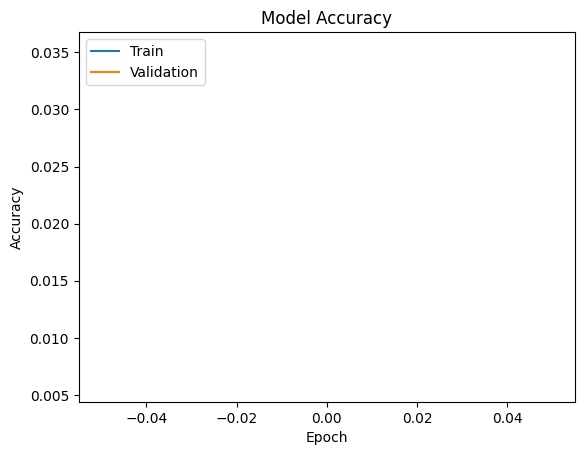

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, acc = model_lstm.evaluate(test_features, test_labels, verbose=1)
print(f"Loss: {loss} \t Accuracy: {acc}")

Loss: 5.95495863685831 	 Accuracy: 0.017543859779834747


# GRU Model

In [ ]:
# Define model with gru layer
def create_model_gru(rnn_units, dropout):

    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=max_sequence_len-1),
        Bidirectional(GRU(rnn_units, dropout=dropout)),
        Dense(VOCAB_SIZE, activation='softmax')
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
model_gru = create_model_gru(rnn_units_best, dropout_best)

history_gru = model_gru.fit(train_features, train_labels, epochs=EPOCH, verbose=1, validation_data=(val_features, val_labels))

Train on 510 samples, validate on 170 samples
510/510 [==============================] - 21s 41ms/sample - loss: 6.0118 - accuracy: 0.0412 - val_loss: 5.9462 - val_accuracy: 0.0529
Loss: 5.901117915995637 	 Accuracy: 0.05263157933950424


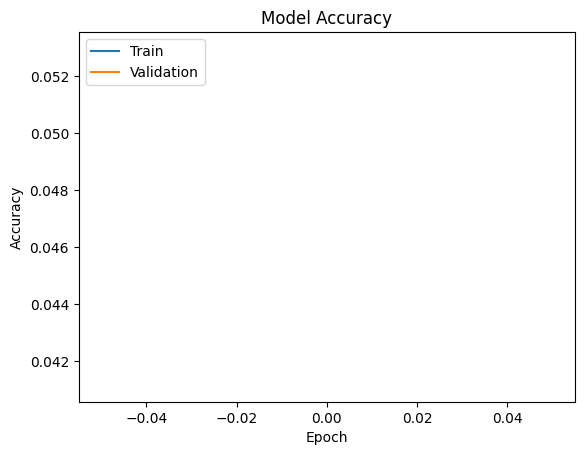

In [ ]:
# Plot the training and validation accuracy
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
loss_gru, acc_gru = model_gru.evaluate(test_features, test_labels, verbose=1)
print(f"Loss: {loss_gru} \t Accuracy: {acc_gru}")

# Downloading the model and tokenizer
- `model.h5`: used to predict the output word in the deployment stage.
- `tokenizer.pkl`: used to tokenize the words in the deployment stage.

In [ ]:
# # Save the model
# model_lstm.save('model.h5')

# # Save the tokenizer
# with open('tokenizer.pkl', 'wb') as handle:
#     pkl.dump(tokenizer, handle)

## Test the model
Run the cell below and let the model generate the next 20 words of a seed text. You can change the seed text to whatever you want.

### LSTM predict

In [ ]:
seed_text = "please do not"
next_words = 20

for _ in range(next_words):
	seed_text_gru = seed_text
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Get the probabilities of predicting a word
	predicted = model_lstm.predict(token_list, verbose=0)
	predicted_gru = model_gru.predict(token_list, verbose=0)
	
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	predicted_gru = np.argmax(predicted_gru, axis=-1).item()
	
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	output_word_gru = tokenizer.index_word[predicted_gru]
	
	# Append to the current text
	seed_text += " " + output_word
	seed_text_gru += " " + output_word_gru

print(f"This is the predicted text using LSTM: \n{seed_text}")
print(f"This is the predicted text using GRU: \n{seed_text_gru}")

NameError: name 'tokenizer' is not defined